## Team5 : Image Captioning using Deep Learning (COCO Dataset)

### Problem Statement - Given an image, we want to obtain a sentence which describes what it consists of.


In [1]:
%load_ext autoreload
%autoreload 2

#### Importing required packages
- We are using pytorch because of it's efficiency in image captioning and natural language processing

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
import sys
from pycocotools.coco import COCO
import math
import torch.utils.data as data
import numpy as np
import os
import requests
import time

from utils import train
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN



#### Dataset description
- We are going to use the COCO (Common Objects in Context) dataset for training the model. 
- COCO is a commonly used dataset for such tasks since one of the target family for COCO is captions. 
- Every image comes with 5 different captions produced by different humans, hence every caption is slightly (sometimes greatly) different from the other captions for the same image.
- Under both Images and Annotations, the ratio of the train, validation and test data are given as follows - Training Data	83K/13GB Validation Data	41K/6GB Test Data	41K/GB


#### Transforming Input Images

- We need to perform preprocessing or transformation – pixel values must be in the range [0,1] and we must then normalize the image by the mean and standard deviation of the ImageNet images' RGB channels.
- mean = [0.485, 0.456, 0.406] std = [0.229, 0.224, 0.225]
- Also, PyTorch follows the NCHW convention, which means the channels dimension (C) must precede the size dimensions.
- We will resize all MSCOCO images to 256x256 for uniformity.
- Images fed to the model must be a Float tensor of dimension N, 3, 256, 256, and must be normalized by the aforesaid mean and standard deviation. N is the batch size

In [24]:
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Define a transform to pre-process the validation images
transform_val = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.CenterCrop(224),                      # get 224x224 crop from the center
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#### Data Loading -
- Here we define the standard batch size of 32 for effective loading and traversing of 44000 images. We have created a get_loader() function which takes input as transformed train dataset, batch_size, vocab-threshold and vocab_file
- vocab_from_file consists of boolean to reference if we want to take words stored inside voacbulary.pkl file

In [25]:
# Set values for the training variables
batch_size = 32         # batch size
vocab_threshold = None  # minimum word count threshold
vocab_from_file = True  # if True, load existing vocab file


# Build data loader, applying the transforms
train_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)



# The size of the vocabulary
vocab_size = len(train_loader.dataset.vocab)



loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
[0/202654] Tokenizing captions...
[100000/202654] Tokenizing captions...
[200000/202654] Tokenizing captions...
loading annotations into memory...
Done (t=0.24s)
creating index...


  0%|          | 674/202654 [00:00<00:29, 6733.42it/s]

index created!
Obtaining caption lengths...


100%|██████████| 202654/202654 [00:26<00:00, 7666.00it/s] 


- The task of image captioning can be divided into two modules logically – "one is an image based model"(Encoder) – which extracts the features and nuances out of our image, and the other is a "language based model"(Decoder) – which translates the features and objects given by our image based model to a natural sentence.
- Hence, we can map our data from the image space into some hidden space(Encoder) and then map that hidden space into the sentence space(Decoder)

#### Encoder - 
- The Encoder encodes the input image with 3 color channels into a smaller image with "learned" channels.
- This smaller encoded image is a summary representation of all that's useful in the original image.
- Since we want to encode images, we use Convolutional Neural Networks (CNNs).
- Here we are not training the images from scratch, but instead using the concept of transfer learning. There are already many CNN's trained to capture to capture the essence of the iamge very well
- We have chosen to use the 50 layered Residual Network trained on ImageNet classification task, already available in Pytorch

#### Decoder -
- For decoder we rely on Recurrent Neural Network,job is to look at the encoded image and generate a caption word by word.
- Since it's generating a sequence, we are using LSTM (RNN network)
- We are using RNN without attention model, where we are simply averaging the encoded image across all pixels.
- We feed this with linear transformation into the Decoder and it generates its first hidden state and generate the caption. Each predicted word is used to generate the next word.

In [44]:
embed_size = 256 # dimensionality of image and word embeddings
hidden_size = 512 # number of features in hidden state of the RNN decoder
num_epochs = 2 

# Initialize the encoder and decoder
encoder = EncoderCNN(embed_size)

decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available
if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

 #### Loss function -
- Since we're generating a sequence of words, we use CrossEntropyLoss. We need to submit the raw scores from the final layer in the Decoder, and the loss function will perform the operations.
#### Optimizer -
- In terms of optimizer, we have used Adam optimizer algorithm to update the network weights iteratively based on training data


In [45]:
# Define the loss function
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Specify the learnable parameters of the model
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.bn.parameters())

# Define the optimizer
optimizer = torch.optim.Adam(params=params, lr=0.001)

In [46]:
# Set the total number of training and validation steps per epoch
total_train_step = math.ceil(len(train_loader.dataset.caption_lengths) / train_loader.batch_sampler.batch_size)
#total_val_step = math.ceil(len(val_loader.dataset.caption_lengths) / val_loader.batch_sampler.batch_size)
print ("Number of training steps:", total_train_step)
#print ("Number of validation steps:", total_val_step)

Number of training steps: 6333


#### Training -
- Notice that, even though we have two model components, i.e. encoder and decoder, we train them jointly by passing the output of the encoder, which is the latent space vector, to the decoder, which, in turn, is the recurrent neural network.

- We trained the model on GeForce GTX 1080 with batch size of 32 for 2 epoch, which took around 2 hours. After 1 epochs the results of the model were already pretty good, signifying the convergence of the model.

In [47]:
# Keep track of train and validation losses and validation Bleu-4 scores by epoch
train_losses = []
val_losses = []
val_bleus = []
# Keep track of the current best validation Bleu score
best_val_bleu = float("-INF")

start_time = time.time()
for epoch in range(1, num_epochs + 1):
    train_loss = train(train_loader, encoder, decoder, criterion, optimizer, 
                       vocab_size, epoch, total_train_step)
    train_losses.append(train_loss)
    filename = os.path.join("./models", "model-{}.pkl".format(epoch))
    #save_epoch(filename, encoder, decoder, optimizer, train_losses, val_losses, 
     #        val_bleu, val_bleus, epoch)
    print ("Epoch [%d/%d] took %ds" % (epoch, num_epochs, time.time() - start_time))
    if epoch > 5:
        # Stop if the validation Bleu doesn't improve for 3 epochs
        if early_stopping(val_bleus, 3):
            break
    start_time = time.time()

Epoch 1, Train step [100/6333], 53s, Loss: 4.0780, Perplexity: 59.0301
Epoch 1, Train step [200/6333], 53s, Loss: 3.5360, Perplexity: 34.32982
Epoch 1, Train step [300/6333], 53s, Loss: 3.5311, Perplexity: 34.1602
Epoch 1, Train step [400/6333], 53s, Loss: 3.5145, Perplexity: 33.59814
Epoch 1, Train step [500/6333], 53s, Loss: 3.4403, Perplexity: 31.1961
Epoch 1, Train step [600/6333], 53s, Loss: 3.5508, Perplexity: 34.8402
Epoch 1, Train step [700/6333], 54s, Loss: 3.0494, Perplexity: 21.1037
Epoch 1, Train step [800/6333], 53s, Loss: 3.0051, Perplexity: 20.1879
Epoch 1, Train step [900/6333], 53s, Loss: 3.4033, Perplexity: 30.06234
Epoch 1, Train step [1000/6333], 52s, Loss: 2.9180, Perplexity: 18.5043
Epoch 1, Train step [1100/6333], 52s, Loss: 2.9635, Perplexity: 19.3663
Epoch 1, Train step [1200/6333], 53s, Loss: 3.2378, Perplexity: 25.4786
Epoch 1, Train step [1300/6333], 55s, Loss: 2.5430, Perplexity: 12.7181
Epoch 1, Train step [1400/6333], 54s, Loss: 2.7463, Perplexity: 15.584

## Testing

In [9]:
%load_ext autoreload
%autoreload 2

import os
from pycocotools.coco import COCO
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
from utils import clean_sentence, get_prediction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Defining the transformations for test data

In [3]:
# Define a transform to pre-process the testing images
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.CenterCrop(224),                      # get 224x224 crop from the center
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Create the data loader
data_loader = get_loader(transform=transform_test,    
                         mode='test')

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
[0/202654] Tokenizing captions...
[100000/202654] Tokenizing captions...
[200000/202654] Tokenizing captions...


#### Obtain sample image before and after pre-processing

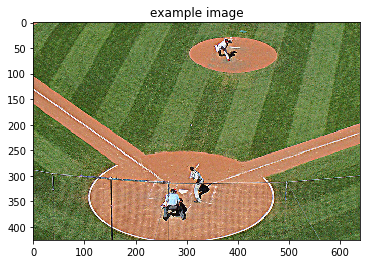

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


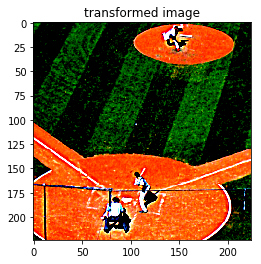

In [4]:
# Obtain sample image before and after pre-processing
orig_image, image = next(iter(data_loader))
# Convert image from torch.FloatTensor to numpy ndarray
transformed_image = image.numpy()
# Remove the first dimension which is batch_size euqal to 1
transformed_image = np.squeeze(transformed_image)
transformed_image = transformed_image.transpose((1, 2, 0))

# Visualize sample image, before pre-processing
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()
# Visualize sample image, after pre-processing
plt.imshow(transformed_image)
plt.title('transformed image')
plt.show()

In [5]:
image #looking up tensors generated by cnn

tensor([[[[-0.3369, -0.0629, -0.3027,  ..., -0.8507, -0.7308, -0.6452],
          [-0.4739, -0.4226, -0.3541,  ..., -0.7308, -0.8164, -0.8164],
          [-0.4739, -0.5596, -0.3712,  ..., -0.8164, -0.6623, -0.7308],
          ...,
          [-0.2513, -0.0116, -0.5082,  ..., -0.5938, -0.5767, -0.1486],
          [-0.4568, -0.2342, -0.3541,  ..., -0.3712, -0.4054,  0.5364],
          [-0.3541, -0.2342, -0.4397,  ..., -0.3369, -0.3712, -0.2856]],

         [[ 0.3102,  0.4153,  0.2227,  ..., -0.1099,  0.0651,  0.1001],
          [ 0.2752,  0.3277,  0.3627,  ..., -0.2850, -0.1275, -0.0574],
          [ 0.2577,  0.3803,  0.5903,  ..., -0.1275,  0.1001, -0.0924],
          ...,
          [ 0.1001,  0.3452, -0.0574,  ...,  0.1352,  0.1001,  0.2927],
          [ 0.0476,  0.1702,  0.1001,  ...,  0.3803,  0.0126,  0.2227],
          [ 0.4153,  0.1702,  0.0476,  ..., -0.0924, -0.0574,  0.0651]],

         [[-0.6890, -0.6018, -0.9330,  ..., -0.8807, -0.8633, -0.7936],
          [-0.7413, -0.7936, -

In [10]:
# Load the most recent checkpoint
checkpoint = torch.load(os.path.join('state_team5', 'train-model-26300.pkl'))

# Specify values for embed_size and hidden_size - we use the same values as in training step
embed_size = 256
hidden_size = 512

# Get the vocabulary and its size
vocab = data_loader.dataset.vocab
vocab_size = len(vocab)

# Initialize the encoder and decoder, and set each to inference mode
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the pre-trained weights
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

# Move models to GPU if CUDA is available.
if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()


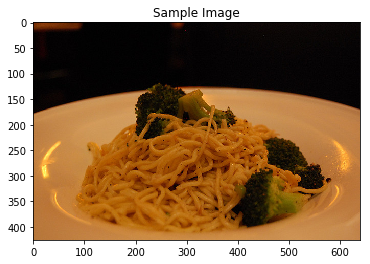

Caption without beam search:
a plate of food with meat and vegetables .
Top captions using beam search:
a close up of a plate of food on a table
a close up of a plate of food on a table
a close up of a plate of food on a table


In [20]:
get_prediction(data_loader, encoder, decoder, vocab)

### Areas of development -
- Using Attention models – Using attention models help us in fine tuning our model performance.In image captioning, you consider some pixels more important than others. In sequence to sequence tasks like machine translation, you consider some words more important than others.
- Moving on to bigger and better techniques - We could also use Reinforcement learning techniques, which currently an evolving topic in world of data science
 